# Clustering Analysis - Finding Hidden Groups in Data

This notebook will teach you how to use unsupervised machine learning to find hidden patterns and groups in your data.

**What we'll learn:**
1. Load and prepare data for clustering
2. Use K-means clustering to find groups
3. Try hierarchical clustering to build cluster trees
4. Apply DBSCAN to find density-based clusters
5. Compare different clustering methods
6. Visualise our results

**What is clustering?**
Clustering finds natural groups in data without being told what to look for. It's like sorting your music collection into genres when you don't know the genre names beforehand!

**Instructions:**
- Make sure you have clean data from the data cleaning notebook
- Run each cell one by one
- Try different numbers of clusters!

In [ ]:
# Import libraries for clustering and visualisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Set up nice-looking plots
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Ready to find hidden groups in your data!")

## 1. Load and Explore Your Data

Let's start by loading our clean data and preparing it for clustering.

In [ ]:
# Load your clean data
df = pd.read_csv('../datasets/cleaned_data.csv')

print(f"Data loaded successfully!")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")

# Look at the data
print("\nFirst few rows:")
df.head()

In [ ]:
# Get basic information about our data
print("Dataset information:")
print("=" * 50)
df.info()

print(f"\nDataset summary:")
print(f"- Total rows: {len(df)}")
print(f"- Total columns: {len(df.columns)}")
print(f"- Numerical columns: {len(df.select_dtypes(include=[np.number]).columns)}")
print(f"- Text columns: {len(df.select_dtypes(include=['object']).columns)}")

## 2. Prepare Data for Clustering

Clustering can work with both numerical and categorical data, but we need to prepare them properly.

**Key steps:**
1. **Feature Selection**: Choose which variables to cluster on
2. **Categorical Encoding**: Convert text categories to numbers
3. **Standardisation**: Make sure all features have equal importance
4. **Feature Assessment**: Check which features will be most useful

**Important note**: Many datasets have their most important information in categorical features (like job titles, locations, etc.), so we'll include these when appropriate!

In [ ]:
# Inspect features for clustering
# Let's examine both numerical and categorical features in detail
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

print("🔍 DETAILED FEATURE INSPECTION")
print("=" * 60)

print("📊 NUMERICAL FEATURES:")
if len(numerical_features) > 0:
    for i, feature in enumerate(numerical_features, 1):
        min_val = df[feature].min()
        max_val = df[feature].max()
        mean_val = df[feature].mean()
        print(f"{i}. {feature}")
        print(f"   Range: {min_val:.1f} to {max_val:.1f} (mean: {mean_val:.1f})")
else:
    print("   No numerical features found")

print(f"\n📝 CATEGORICAL FEATURES:")
if len(categorical_features) > 0:
    for i, feature in enumerate(categorical_features, 1):
        n_categories = df[feature].nunique()
        top_categories = df[feature].value_counts().head(3)
        print(f"{i}. {feature}")
        print(f"   Categories: {n_categories} unique values")
        print(f"   Top 3: {list(top_categories.index)} ({list(top_categories.values)})")
        if n_categories > 20:
            print(f"   ⚠️  Warning: Many categories - might create too many features when encoded")
        print()
else:
    print("   No categorical features found")

print(f"\n💡 FEATURE SELECTION GUIDANCE:")
print(f"- Numerical features: {len(numerical_features)} available")
print(f"- Categorical features: {len(categorical_features)} available")
print(f"- Choose features that you think will help group similar data points")
print(f"- Avoid categorical features with too many categories (>20)")
print(f"- Consider which features contain meaningful differences between groups")

In [ ]:
# MANUAL FEATURE SELECTION
# Based on the inspection above, choose which features to include for clustering

# 1. Choose numerical features (list the column names you want)
selected_numerical_features = [
    # Add numerical column names here, for example:
    # 'salary_in_usd',
    # 'remote_ratio',
    # Add more as needed...
]

# 2. Choose categorical features (list the column names you want)
selected_categorical_features = [
    # Add categorical column names here, for example:
    # 'experience_level',
    # 'company_size',
    # Add more as needed...
]

print("🎯 YOUR FEATURE SELECTION:")
print("=" * 50)
print(f"Selected numerical features: {selected_numerical_features}")
print(f"Selected categorical features: {selected_categorical_features}")

# Validate selections
valid_numerical = [f for f in selected_numerical_features if f in numerical_features]
valid_categorical = [f for f in selected_categorical_features if f in categorical_features]

if len(valid_numerical) != len(selected_numerical_features):
    print("⚠️  Some numerical features not found in dataset")
if len(valid_categorical) != len(selected_categorical_features):
    print("⚠️  Some categorical features not found in dataset")

print(f"\n✓ Valid numerical features: {len(valid_numerical)}")
print(f"✓ Valid categorical features: {len(valid_categorical)}")
print(f"✓ Total features for clustering: {len(valid_numerical) + len(valid_categorical)}")

if len(valid_numerical) + len(valid_categorical) == 0:
    print(f"\n💡 To get started, try adding some features:")
    print(f"   For this dataset, good choices might be:")
    print(f"   - Numerical: 'salary_in_usd', 'remote_ratio'")
    print(f"   - Categorical: 'experience_level', 'company_size'")
    print(f"   (Avoid features with too many categories!)")

### 📝 Feature Selection Instructions

Now you need to choose which features to use for clustering. Look at the inspection above and consider:

**For numerical features:**
- Choose features that vary meaningfully between different groups
- Avoid features that are mostly the same for everyone
- Consider what differences might create natural groups

**For categorical features:**
- Choose features with reasonable number of categories (ideally 2-20)
- Avoid features with too many unique values (they'll create too many columns)
- Think about which categories might group similar data points together

**Examples for typical datasets:**
- **Salary data**: salary_in_usd, experience_level, job_title, company_location (categorical)
- **Customer data**: age, income (numerical) + region, product_preference, membership_type (categorical)
- **Survey data**: ratings, scores (numerical) + demographics, preferences (categorical)

In [ ]:
# Create feature matrix from your selected features
print("🔧 CREATING FEATURE MATRIX")
print("=" * 50)

# Ensure we have the validation variables (in case cells were run out of order)
if 'valid_numerical' not in locals() or 'valid_categorical' not in locals():
    print("⚠️  Validating feature selections...")
    # Re-run validation in case previous cell wasn't executed
    valid_numerical = [f for f in selected_numerical_features if f in numerical_features]
    valid_categorical = [f for f in selected_categorical_features if f in categorical_features]
    
    if len(valid_numerical) != len(selected_numerical_features):
        print("⚠️  Some numerical features not found in dataset")
    if len(valid_categorical) != len(selected_categorical_features):
        print("⚠️  Some categorical features not found in dataset")
    
    print(f"✓ Valid numerical features: {len(valid_numerical)}")
    print(f"✓ Valid categorical features: {len(valid_categorical)}")

feature_frames = []

# Add numerical features
if len(valid_numerical) > 0:
    X_numerical = df[valid_numerical].copy()
    feature_frames.append(X_numerical)
    print(f"✓ Added {len(valid_numerical)} numerical features")
    print(f"  Features: {valid_numerical}")
else:
    print("ℹ️  No numerical features selected")

# Add encoded categorical features
if len(valid_categorical) > 0:
    print(f"\n🔤 Encoding categorical features...")
    categorical_encoded_frames = []
    
    for feature in valid_categorical:
        n_categories = df[feature].nunique()
        print(f"  Encoding {feature}: {n_categories} categories")
        
        # One-hot encode the feature
        encoded = pd.get_dummies(df[feature], prefix=feature, drop_first=True)
        categorical_encoded_frames.append(encoded)
        print(f"    → Created {encoded.shape[1]} binary features")
    
    # Combine categorical features
    if categorical_encoded_frames:
        X_categorical = pd.concat(categorical_encoded_frames, axis=1)
        feature_frames.append(X_categorical)
        print(f"✓ Total encoded categorical features: {X_categorical.shape[1]}")
else:
    print("ℹ️  No categorical features selected")

# Combine all selected features
if feature_frames:
    X = pd.concat(feature_frames, axis=1)
    print(f"\n✅ FEATURE MATRIX CREATED")
    print(f"   Shape: {X.shape}")
    print(f"   Total features: {X.shape[1]}")
    print(f"   Sample feature names: {list(X.columns)[:5]}...")
    if X.shape[1] > 5:
        print(f"   ... and {X.shape[1] - 5} more")
    
    # Store clustering features for later use
    clustering_features = list(X.columns)
else:
    print("❌ ERROR: No features selected! Please choose at least one feature above.")
    X = pd.DataFrame()  # Empty dataframe
    clustering_features = []

In [ ]:
# Standardise the features (very important for clustering!)
print("Standardising features...")
print("This makes sure all features have equal importance")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("✓ Features standardised!")
print(f"All features now have mean ≈ 0 and standard deviation ≈ 1")

# Show the difference
if len(numerical_features) > 0:
    print(f"\nBefore standardisation (numerical features):")
    numerical_ranges = df[numerical_features].max() - df[numerical_features].min()
    print(f"Feature ranges: {numerical_ranges.round(1)}")

print(f"\nAfter standardisation (all features):")
standardised_ranges = X_scaled.max() - X_scaled.min()
print(f"Feature ranges: {standardised_ranges.round(1).head()}")

print(f"\n🔍 Why standardisation matters:")
print(f"- Without it: features with large values dominate clustering")
print(f"- With it: all features contribute equally to cluster formation")
print(f"- Essential when mixing numerical and categorical features!")

## 3. K-Means Clustering

K-means finds a specific number of clusters by grouping similar data points together.
This can take a few minutes, since it is running multiple possible numbers of clusters. 

In [ ]:
# First, let's try to find the best number of clusters
print("Finding the best number of clusters...")
print("We'll try different numbers and see which works best")

# Try different numbers of clusters
cluster_range = range(2, 11)  # Try 2 to 10 clusters
inertias = []  # Within-cluster sum of squares
silhouette_scores = []

for n_clusters in cluster_range:
    # Fit K-means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Calculate metrics
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))

print("✓ Tested different numbers of clusters!")

In [ ]:
# Plot the results to help choose the best number of clusters
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Elbow plot
ax1.plot(cluster_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia (Within-cluster sum of squares)')
ax1.set_title('Elbow Method')
ax1.grid(True, alpha=0.3)

# Silhouette score plot
ax2.plot(cluster_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find the best number based on silhouette score
best_n_clusters = cluster_range[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)

print(f"📊 Results:")
print(f"Best number of clusters: {best_n_clusters}")
print(f"Best silhouette score: {best_silhouette:.3f}")
print(f"\nSilhouette score interpretation:")
print(f"- 0.7+ = Excellent clustering")
print(f"- 0.5+ = Good clustering")
print(f"- 0.3+ = Reasonable clustering")
print(f"- Below 0.3 = Poor clustering")

In [ ]:
# Apply K-means with the best number of clusters
print(f"Applying K-means with {best_n_clusters} clusters...")

kmeans_best = KMeans(n_clusters=best_n_clusters, random_state=42, n_init=10)
kmeans_labels = kmeans_best.fit_predict(X_scaled)

# Add cluster labels to our original data
df_kmeans = df.copy()
df_kmeans['KMeans_Cluster'] = kmeans_labels

print(f"✓ K-means clustering complete!")
print(f"Silhouette score: {silhouette_score(X_scaled, kmeans_labels):.3f}")

# Show cluster sizes
cluster_sizes = pd.Series(kmeans_labels).value_counts().sort_index()
print(f"\nCluster sizes:")
for cluster, size in cluster_sizes.items():
    print(f"Cluster {cluster}: {size} data points")

## 4. Hierarchical Clustering

Hierarchical clustering builds a tree of clusters, showing how groups relate to each other.

In [ ]:
# Apply Hierarchical Clustering
print("Applying Hierarchical Clustering...")
print("This creates a tree showing how clusters are related")

# For large datasets, we might want to use a sample for the dendrogram
sample_size = min(100, len(X_scaled))  # Use up to 100 points for visualisation
if len(X_scaled) > sample_size:
    print(f"Using a sample of {sample_size} points for dendrogram visualisation")
    sample_indices = np.random.choice(len(X_scaled), sample_size, replace=False)
    X_sample = X_scaled.iloc[sample_indices]
else:
    X_sample = X_scaled
    
# Create linkage matrix for dendrogram
linkage_matrix = linkage(X_sample, method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=10)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

print("How to read the dendrogram:")
print("- Height shows how different clusters are")
print("- Lower splits = more similar groups")
print("- Higher splits = more different groups")

In [ ]:
# Apply hierarchical clustering to all data
print(f"Applying hierarchical clustering with {best_n_clusters} clusters...")

hierarchical = AgglomerativeClustering(n_clusters=best_n_clusters, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_scaled)

# Add cluster labels to our data
df_hierarchical = df.copy()
df_hierarchical['Hierarchical_Cluster'] = hierarchical_labels

print(f"✓ Hierarchical clustering complete!")
print(f"Silhouette score: {silhouette_score(X_scaled, hierarchical_labels):.3f}")

# Show cluster sizes
cluster_sizes_hier = pd.Series(hierarchical_labels).value_counts().sort_index()
print(f"\nCluster sizes:")
for cluster, size in cluster_sizes_hier.items():
    print(f"Cluster {cluster}: {size} data points")

## 5. DBSCAN Clustering

DBSCAN finds clusters based on density - it can find oddly-shaped clusters and identify outliers.

In [53]:
# Apply DBSCAN clustering
print("Applying DBSCAN clustering...")
print("DBSCAN finds dense regions and marks sparse points as outliers")

# DBSCAN automatically determines the number of clusters
# We need to set eps (neighbourhood distance) and min_samples
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Add cluster labels to our data
df_dbscan = df.copy()
df_dbscan['DBSCAN_Cluster'] = dbscan_labels

# Count clusters and outliers
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_outliers = list(dbscan_labels).count(-1)

print(f"✓ DBSCAN clustering complete!")
print(f"Number of clusters found: {n_clusters_dbscan}")
print(f"Number of outliers: {n_outliers}")

if n_clusters_dbscan > 1:
    # Only calculate silhouette score if we have multiple clusters
    non_outlier_mask = dbscan_labels != -1
    if np.sum(non_outlier_mask) > 0:
        silhouette_dbscan = silhouette_score(X_scaled[non_outlier_mask], 
                                           dbscan_labels[non_outlier_mask])
        print(f"Silhouette score (excluding outliers): {silhouette_dbscan:.3f}")

# Show cluster sizes
cluster_sizes_dbscan = pd.Series(dbscan_labels).value_counts().sort_index()
print(f"\nCluster sizes:")
for cluster, size in cluster_sizes_dbscan.items():
    if cluster == -1:
        print(f"Outliers: {size} data points")
    else:
        print(f"Cluster {cluster}: {size} data points")

✓ DBSCAN clustering complete!
Number of clusters found: 36
Number of outliers: 78
Silhouette score (excluding outliers): 0.415

Cluster sizes:
Outliers: 78 data points
Cluster 0: 9109 data points
Cluster 1: 15772 data points
Cluster 2: 5768 data points
Cluster 3: 24117 data points
Cluster 4: 4440 data points
Cluster 5: 1839 data points
Cluster 6: 455 data points
Cluster 7: 1273 data points
Cluster 8: 360 data points
Cluster 9: 151 data points
Cluster 10: 433 data points
Cluster 11: 14 data points
Cluster 12: 20 data points
Cluster 13: 58 data points
Cluster 14: 143 data points
Cluster 15: 53 data points
Cluster 16: 122 data points
Cluster 17: 17 data points
Cluster 18: 33 data points
Cluster 19: 53 data points
Cluster 20: 79 data points
Cluster 21: 8 data points
Cluster 22: 14 data points
Cluster 23: 35 data points
Cluster 24: 5 data points
Cluster 25: 11 data points
Cluster 26: 30 data points
Cluster 27: 8 data points
Cluster 28: 18 data points
Cluster 29: 14 data points
Cluster 30: 1

## 6. Compare All Clustering Methods

Let's compare how the three methods performed!

In [54]:
# Create a comparison table
comparison_data = {
    'Method': ['K-Means', 'Hierarchical', 'DBSCAN'],
    'Number_of_Clusters': [
        best_n_clusters,
        best_n_clusters, 
        n_clusters_dbscan
    ],
    'Silhouette_Score': [
        silhouette_score(X_scaled, kmeans_labels),
        silhouette_score(X_scaled, hierarchical_labels),
        silhouette_dbscan if n_clusters_dbscan > 1 else 'N/A'
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("🏆 CLUSTERING METHOD COMPARISON")
print("=" * 50)
print(comparison_df.to_string(index=False))

print(f"\n📚 Method characteristics:")
print(f"• K-Means: Fast, requires number of clusters, round clusters")
print(f"• Hierarchical: Shows cluster relationships, any cluster shape")
print(f"• DBSCAN: Finds outliers, handles noise, automatic cluster count")

🏆 CLUSTERING METHOD COMPARISON
      Method  Number_of_Clusters  Silhouette_Score
     K-Means                   9          0.602293
Hierarchical                   9          0.602479
      DBSCAN                  36          0.414862

📚 Method characteristics:
• K-Means: Fast, requires number of clusters, round clusters
• Hierarchical: Shows cluster relationships, any cluster shape
• DBSCAN: Finds outliers, handles noise, automatic cluster count


## 7. Visualise the Clustering Results

Let's create plots to see how well our clustering methods worked!

In [55]:
# For visualisation, we'll use PCA to reduce dimensions to 2D
print("Creating 2D visualisation using PCA...")
print("PCA helps us see high-dimensional clusters in 2D")

# Apply PCA to reduce to 2 dimensions for plotting
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"✓ Reduced {X_scaled.shape[1]} dimensions to 2 dimensions")
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.1%}")

Creating 2D visualisation using PCA...
PCA helps us see high-dimensional clusters in 2D
✓ Reduced 7 dimensions to 2 dimensions
Explained variance: 45.5%


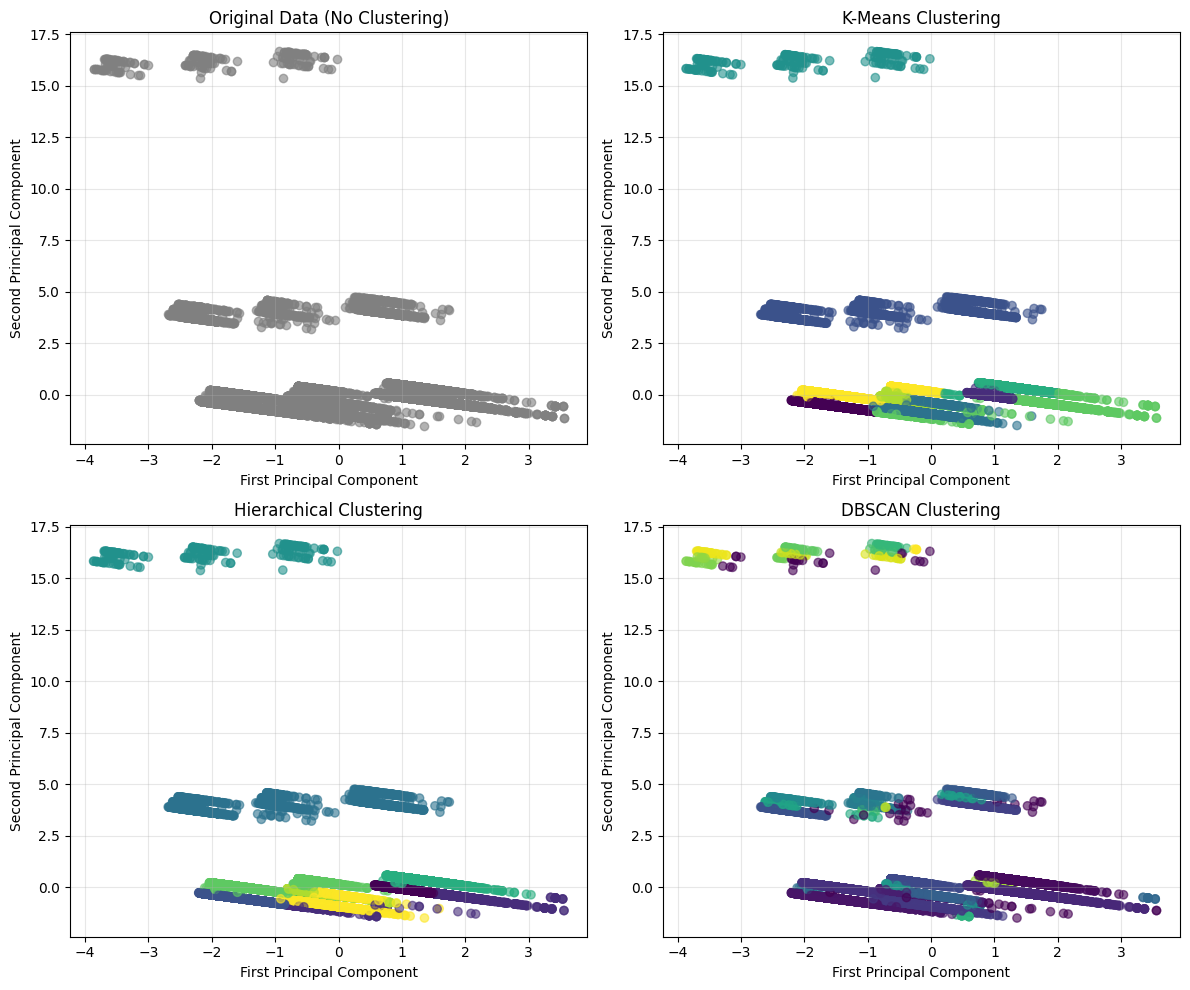

How to interpret these plots:
- Each colour represents a different cluster
- Similar colours = same cluster
- Well-separated colours = good clustering
- In DBSCAN, dark points might be outliers


In [56]:
# Create visualisation plots for all three methods
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original data (no clusters)
axes[0, 0].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, c='gray')
axes[0, 0].set_title('Original Data (No Clustering)')
axes[0, 0].set_xlabel('First Principal Component')
axes[0, 0].set_ylabel('Second Principal Component')
axes[0, 0].grid(True, alpha=0.3)

# K-Means results
scatter1 = axes[0, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, 
                              cmap='viridis', alpha=0.6)
axes[0, 1].set_title('K-Means Clustering')
axes[0, 1].set_xlabel('First Principal Component')
axes[0, 1].set_ylabel('Second Principal Component')
axes[0, 1].grid(True, alpha=0.3)

# Hierarchical results
scatter2 = axes[1, 0].scatter(X_pca[:, 0], X_pca[:, 1], c=hierarchical_labels, 
                              cmap='viridis', alpha=0.6)
axes[1, 0].set_title('Hierarchical Clustering')
axes[1, 0].set_xlabel('First Principal Component')
axes[1, 0].set_ylabel('Second Principal Component')
axes[1, 0].grid(True, alpha=0.3)

# DBSCAN results
scatter3 = axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=dbscan_labels, 
                              cmap='viridis', alpha=0.6)
axes[1, 1].set_title('DBSCAN Clustering')
axes[1, 1].set_xlabel('First Principal Component')
axes[1, 1].set_ylabel('Second Principal Component')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("How to interpret these plots:")
print("- Each colour represents a different cluster")
print("- Similar colours = same cluster")
print("- Well-separated colours = good clustering")
print("- In DBSCAN, dark points might be outliers")

## 8. Analyse the Clusters

Let's look at what makes each cluster unique!

In [57]:
# Analyse K-means clusters (usually the most interpretable)
print("🔍 ANALYSING K-MEANS CLUSTERS")
print("=" * 50)

# Calculate cluster centres in original scale
cluster_centres = pd.DataFrame(scaler.inverse_transform(kmeans_best.cluster_centers_), 
                              columns=X.columns)

print("Cluster centres (average values for each feature):")
print(cluster_centres.round(2))

# Show characteristics of each cluster
print(f"\nCluster characteristics:")
for cluster in range(best_n_clusters):
    cluster_data = df_kmeans[df_kmeans['KMeans_Cluster'] == cluster]
    print(f"\n📊 Cluster {cluster} ({len(cluster_data)} points):")
    
    # Show numerical feature averages (use the original selected features)
    features_to_show = valid_numerical[:3] if len(valid_numerical) > 0 else []
    if len(features_to_show) == 0 and len(valid_categorical) > 0:
        # If no numerical features, show some stats about categorical features
        print(f"  Primary categorical features: {valid_categorical[:2]}")
    else:
        # Show numerical feature averages
        for feature in features_to_show:
            if feature in df.columns:
                avg_value = cluster_data[feature].mean()
                overall_avg = df[feature].mean()
                print(f"  {feature}: {avg_value:.1f} (overall average: {overall_avg:.1f})")

🔍 ANALYSING K-MEANS CLUSTERS
Cluster centres (average values for each feature):
   salary_in_usd  remote_ratio  experience_level_EX  experience_level_MI  \
0      134442.24          0.02                 0.00                 1.00   
1      135351.03          0.02                 0.00                 0.00   
2      137453.59         29.52                 0.02                 0.37   
3      201054.04         19.17                 1.00                 0.00   
4       88144.72         65.33                 0.04                 0.35   
5      160851.97         99.97                 0.00                -0.00   
6      287475.99          1.98                 0.00                 0.04   
7       94351.73          0.29                 0.00                -0.00   
8      120995.78         99.87                 0.00                 0.78   

   experience_level_SE  company_size_M  company_size_S  
0                -0.00             1.0            -0.0  
1                 1.00             1.0       


📈 CLUSTER COMPOSITION BY CATEGORIES
Percentage distribution of 'experience_level' in each cluster:
experience_level     EN     EX     MI     SE
KMeans_Cluster                              
0                   0.0    0.0  100.0    0.0
1                   0.0    0.0    0.0  100.0
2                  17.0    1.9   37.1   43.9
3                   0.0  100.0    0.0    0.0
4                  27.4    4.2   34.9   33.5
5                   0.1    0.0    0.0   99.9
6                   2.0    0.0    3.9   94.0
7                 100.0    0.0    0.0    0.0
8                  22.0    0.0   78.0    0.0


<Figure size 1000x600 with 0 Axes>

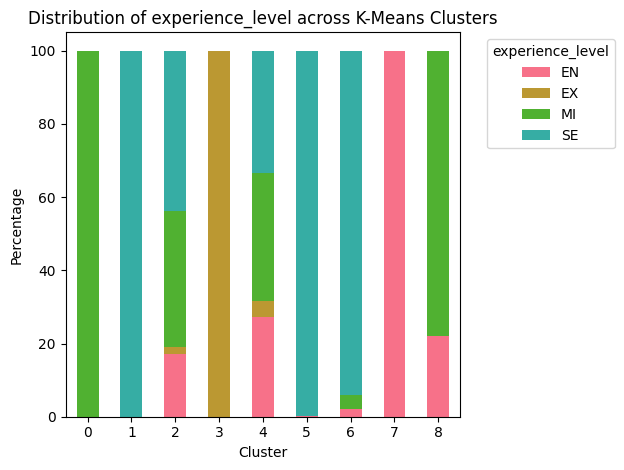

In [58]:
# If we have categorical features, show their distribution in clusters
categorical_features = df.select_dtypes(include=['object']).columns.tolist()

if len(categorical_features) > 0:
    print(f"\n📈 CLUSTER COMPOSITION BY CATEGORIES")
    print("=" * 50)
    
    # Show distribution of first categorical feature across clusters
    cat_feature = categorical_features[0]
    
    cluster_composition = pd.crosstab(df_kmeans['KMeans_Cluster'], 
                                    df_kmeans[cat_feature], 
                                    normalize='index') * 100
    
    print(f"Percentage distribution of '{cat_feature}' in each cluster:")
    print(cluster_composition.round(1))
    
    # Plot the composition
    plt.figure(figsize=(10, 6))
    cluster_composition.plot(kind='bar', stacked=True)
    plt.title(f'Distribution of {cat_feature} across K-Means Clusters')
    plt.xlabel('Cluster')
    plt.ylabel('Percentage')
    plt.legend(title=cat_feature, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo categorical features found to analyse cluster composition")

## 9. Practical Applications

Let's see how to use these clusters for practical insights!

In [ ]:
# Save the clustering results
print("💾 SAVING CLUSTERING RESULTS")
print("=" * 50)

# Create a comprehensive results dataset
results_df = df.copy()
results_df['KMeans_Cluster'] = kmeans_labels
results_df['Hierarchical_Cluster'] = hierarchical_labels
results_df['DBSCAN_Cluster'] = dbscan_labels

# Save to CSV
results_df.to_csv('clustered_data.csv', index=False)
print("✓ Results saved to 'clustered_data.csv'")

print(f"\nDataset now includes:")
print(f"- Original features: {len(df.columns)} columns")
print(f"- K-Means clusters: 1 column")
print(f"- Hierarchical clusters: 1 column") 
print(f"- DBSCAN clusters: 1 column")
print(f"- Total: {len(results_df.columns)} columns")

In [ ]:
# Practical example: Using clusters for business insights
print("💡 PRACTICAL APPLICATIONS")
print("=" * 50)

print("How you might use these clusters:")
print("1. 🛍️  Customer Segmentation:")
print("   - Group customers by buying behaviour")
print("   - Create targeted marketing campaigns")
print("   - Personalise product recommendations")

print("\n2. 📊 Market Research:")
print("   - Identify different user types")
print("   - Understand market segments")
print("   - Develop new products for each group")

print("\n3. 🔍 Anomaly Detection:")
print("   - DBSCAN outliers might be unusual cases")
print("   - Could indicate fraud, errors, or special cases")
print("   - Investigate these points separately")

print("\n4. 📈 Data Exploration:")
print("   - Clusters reveal hidden patterns")
print("   - Guide further analysis")
print("   - Suggest new hypotheses to test")

# Show a simple example if we have features
available_features = valid_numerical + valid_categorical
if len(available_features) >= 2:
    feature1, feature2 = available_features[0], available_features[1]
    print(f"\n📋 Example insight:")
    print(f"Looking at {feature1} vs {feature2} in different clusters:")
    
    for cluster in range(min(3, best_n_clusters)):  # Show first 3 clusters
        cluster_data = df_kmeans[df_kmeans['KMeans_Cluster'] == cluster]
        if feature1 in df.columns and feature2 in df.columns:
            if df[feature1].dtype in ['int64', 'float64'] and df[feature2].dtype in ['int64', 'float64']:
                # Both numerical
                avg1 = cluster_data[feature1].mean()
                avg2 = cluster_data[feature2].mean()
                print(f"Cluster {cluster}: {feature1}={avg1:.1f}, {feature2}={avg2:.1f}")
            else:
                # At least one categorical - show mode
                if df[feature1].dtype in ['int64', 'float64']:
                    avg1 = cluster_data[feature1].mean()
                    mode2 = cluster_data[feature2].mode().iloc[0] if len(cluster_data[feature2].mode()) > 0 else "N/A"
                    print(f"Cluster {cluster}: {feature1}={avg1:.1f}, {feature2}={mode2}")
                elif df[feature2].dtype in ['int64', 'float64']:
                    mode1 = cluster_data[feature1].mode().iloc[0] if len(cluster_data[feature1].mode()) > 0 else "N/A"
                    avg2 = cluster_data[feature2].mean()
                    print(f"Cluster {cluster}: {feature1}={mode1}, {feature2}={avg2:.1f}")
                else:
                    # Both categorical
                    mode1 = cluster_data[feature1].mode().iloc[0] if len(cluster_data[feature1].mode()) > 0 else "N/A"
                    mode2 = cluster_data[feature2].mode().iloc[0] if len(cluster_data[feature2].mode()) > 0 else "N/A"
                    print(f"Cluster {cluster}: {feature1}={mode1}, {feature2}={mode2}")
elif len(available_features) == 1:
    feature1 = available_features[0]
    print(f"\n📋 Example insight:")
    print(f"Looking at {feature1} across different clusters:")
    
    for cluster in range(min(3, best_n_clusters)):
        cluster_data = df_kmeans[df_kmeans['KMeans_Cluster'] == cluster]
        if feature1 in df.columns:
            if df[feature1].dtype in ['int64', 'float64']:
                avg1 = cluster_data[feature1].mean()
                print(f"Cluster {cluster}: {feature1}={avg1:.1f}")
            else:
                mode1 = cluster_data[feature1].mode().iloc[0] if len(cluster_data[feature1].mode()) > 0 else "N/A"
                print(f"Cluster {cluster}: {feature1}={mode1}")
else:
    print(f"\n📋 No features selected for detailed analysis")
    print(f"   Run the feature selection cells above to see insights")

## 10. Summary and Next Steps

**🎉 Congratulations! You've successfully applied three different clustering methods!**

**What we learned:**
- How to prepare data for clustering (standardisation is crucial!)
- How to apply K-means clustering to find a specific number of groups
- How to use hierarchical clustering to understand cluster relationships  
- How to apply DBSCAN to find density-based clusters and outliers
- How to compare different clustering methods
- How to visualise and interpret clustering results

**Key takeaways:**
- **K-Means**: Best when you know roughly how many groups to expect
- **Hierarchical**: Great for understanding how clusters relate to each other
- **DBSCAN**: Excellent for finding outliers and handling noise in data

**Try this next:**
1. Experiment with different numbers of clusters in K-means
2. Try different distance metrics in hierarchical clustering
3. Adjust DBSCAN parameters (eps and min_samples) to find different patterns
4. Apply clustering to different features or datasets
5. Use cluster labels to guide supervised learning

**Remember:**
- Always standardise your features before clustering
- Different methods can give different insights
- Clustering results should make sense in your domain
- Use multiple methods to validate your findings

### 💡 Troubleshooting Tips

**Common clustering issues and solutions:**

1. **Poor cluster separation:**
   - Try different numbers of clusters
   - Check if features need different preprocessing
   - Consider feature selection or dimensionality reduction

2. **DBSCAN finds no clusters:**
   - Increase eps parameter (larger neighbourhood)
   - Decrease min_samples parameter
   - Check if data needs different scaling

3. **All methods give different results:**
   - This is normal! Each method has different assumptions
   - Choose the method that makes most sense for your problem
   - Consider the domain knowledge

4. **Clusters don't make business sense:**
   - Try different feature combinations
   - Add domain-specific features
   - Consider supervised learning instead

**Remember**: Clustering is exploratory - there's often no single "correct" answer!